# FaceScape Bilinear Model - fit 3D/2D landmarks

This demo shows how to use FaceScape bilinear model to fit 2D or 3D landmarks using an optimization scheme. Please make sure the environmenthave been prepared following [README-toolkit](https://github.com/zhuhao-nju/facescape/blob/master/toolkit/README.md). Please note that this demos only works for bilinear model version >= 1.6.

### (1) demo to fit 2D landmarks

Here is a demo to fit the landmarks extracted from a single image.
* Please download **'facescape_bilinear_model_v1.6.zip'** from [FaceScape website](https://facescape.nju.edu.cn/) or from the [external_link](https://github.com/zhuhao-nju/facescape_debug/blob/master/doc/external_link_fsbm.md), then extract the npz files to "/toolkit/bilinear_model_v1.6/".

* please install dlib package by executing `pip install dlib`. Then download the model of landmarkd predictor from `http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2`, and extract the model file `shape_predictor_68_face_landmarks.dat` to `/toolkit/predef/`.

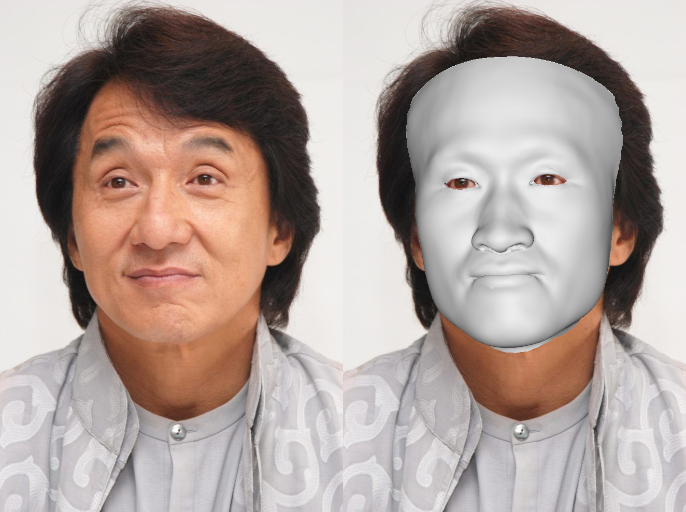

In [1]:
import numpy as np, cv2, trimesh
from src.facescape_fitter import facescape_fitter
from src.utility import show_img_arr
from src.renderer import render_orthcam

fs_fitter = facescape_fitter(fs_file = "./bilinear_model_v1.6/facescape_bm_v1.6_847_50_52_id_front.npz", 
                             lm_file = "./predef/shape_predictor_68_face_landmarks.dat")

src_img = cv2.imread("./test_data/chan.jpg")

kp2d = fs_fitter.detect_kp2d(src_img) # extract 2D key points
mesh, _ = fs_fitter.fit_kp2d(kp2d) # fit model

# ========== Visualize Result ==========
# transform to orthogonal camera coordinate
mesh_tm = trimesh.Trimesh(vertices = mesh.vertices.copy(), 
                          faces = fs_fitter.fv_indices_front-1, 
                          process = False)
mesh_tm.vertices[:, :2] = mesh_tm.vertices[:, 0:2] - np.array([src_img.shape[1] / 2, src_img.shape[0] / 2])
mesh_tm.vertices = mesh_tm.vertices / src_img.shape[0] * 2
mesh_tm.vertices[:, 2] = mesh_tm.vertices[:, 2] - 10

# render texture image and depth
rend_depth, rend_tex = render_orthcam(mesh_tm, (1, 1), 
                                      rend_size = tuple(src_img.shape[:2]), 
                                      flat_shading=False)
mask = np.stack((rend_depth!=0, )*3, 2)
res_img = src_img.copy()
res_img[mask] = rend_tex[mask]

# visualize
vis_scale = 512. / np.max(src_img.shape[:2])
sc_img = cv2.resize(src_img, (round(src_img.shape[1]*vis_scale), 
                              round(src_img.shape[0]*vis_scale)))

sc_res_img = cv2.resize(res_img, (round(src_img.shape[1]*vis_scale), 
                                  round(src_img.shape[0]*vis_scale)))
show_img_arr(np.concatenate((sc_img, sc_res_img), 1), bgr_mode = True)


### (2) demo to fit 3D landmarks

Here is a demo to fit the given 3D landmarks (key points). 

* Please download **'facescape_bilinear_model_v1.6.zip'** from [FaceScape website](https://facescape.nju.edu.cn/) or from the [external_link](https://github.com/zhuhao-nju/facescape_debug/blob/master/doc/external_link_fsbm.md), then extract the npz files to "/toolkit/bilinear_model/". 


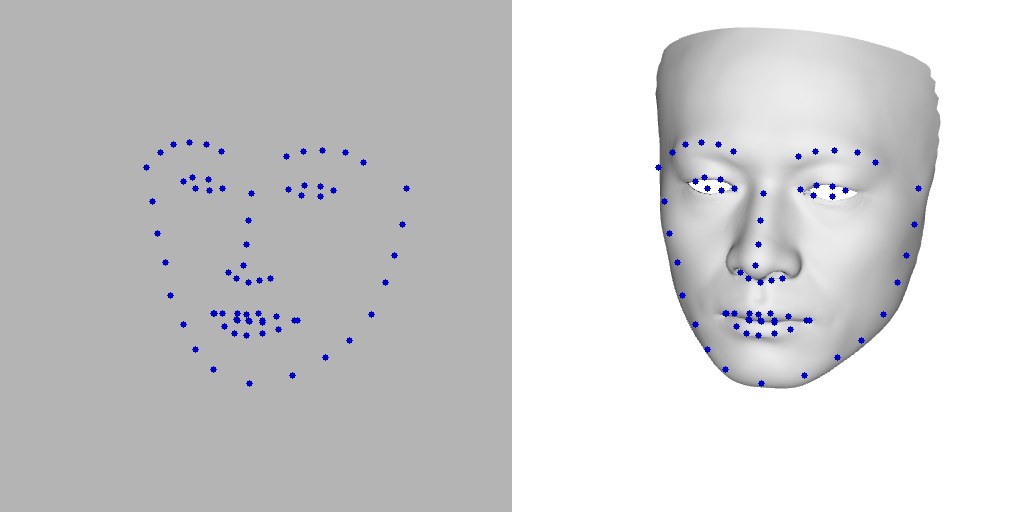

In [1]:
import numpy as np, cv2, trimesh
from src.facescape_fitter import facescape_fitter
from src.utility import show_img_arr
from src.renderer import render_orthcam, render_cvcam
from src.camera import CamPara

fs_fitter = facescape_fitter(fs_file = "../../bilinear_model_0325/integrated_model/facescape_bm_v1.6_847_50_52_id_front_new.npz")

kp3d = np.loadtxt("../samples/sample_keypoint3d.txt")

mesh, _ = fs_fitter.fit_kp3d(kp3d)

# ========== Visualize Result ==========
# render result mesh
K = np.array([[2000, 0, 256],
              [0, 2000, 256],
              [0, 0, 1]], dtype=np.float64)
Rt = np.hstack((np.eye(3), np.zeros((3, 1))))

mesh_tm = trimesh.Trimesh(vertices = mesh.vertices.copy(), 
                          faces = fs_fitter.fv_indices_front-1, 
                          process = False)
_, rend_tex = render_cvcam(mesh_tm, K=K, Rt=Rt, light_trans = np.zeros((3, 1)))

# draw 3D key point
kp3d_img = np.ones((512, 512, 3), dtype = np.uint8) * 180
mesh_img = rend_tex.copy()

cam = CamPara(K=K, Rt=Rt)
for kp in kp3d:
    u, v = np.round(cam.project(kp)).astype(np.int)
    cv2.circle(kp3d_img, (u, v), 3, (0, 0, 200), -1)
    cv2.circle(mesh_img, (u, v), 3, (0, 0, 200), -1)

show_img_arr(np.concatenate((kp3d_img, mesh_img), 1))
